In [1]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 7.9MB/s 


In [2]:
!pip install nbdev

     |████████████████████████████████| 61kB 4.6MB/s 


In [3]:
import numpy as np
import pandas as pd

import gc
import random

from fastai2.vision.all import *
from fastai2.vision.widgets import *


Connect to Kaggle, to download the dataset

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

In [8]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 440M/450M [00:08<00:00, 64.8MB/s]
100% 450M/450M [00:08<00:00, 53.9MB/s]


In [9]:
print(os.getcwd())

/content


In [10]:
os.listdir('/content')

['.config', 'flowers-recognition.zip', 'kaggle.json', 'sample_data']

In [ ]:
!unzip '/content/flowers-recognition.zip' -d data

In [35]:
#Delete any image not ending with jpg extension
lstDirectories = ['/content/data/flowers/daisy', '/content/data/flowers/dandelion' , '/content/data/flowers/rose',
                  '/content/data/flowers/sunflower', '/content/data/flowers/tulip' ]

for i in range(len(lstDirectories)):
  for fil in os.listdir(lstDirectories[i]):
    if not(fil.endswith('.jpg')):
      os.remove (lstDirectories[i] + '/' +  fil)

del lstDirectories
gc.collect()

1169

--

In [36]:
#Set Seed
seed = 42

In [37]:
def random_seed(seed_value, use_cuda=True):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) 
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False

In [39]:
random_seed(seed, use_cuda = True)

Data Block

In [40]:
#Create the DataBlock.
Flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items= get_files, 
                 splitter=RandomSplitter(seed=seed, valid_pct=0.2),
                 get_y= parent_label,
                 item_tfms=Resize(230),
                 batch_tfms=aug_transforms(size=224, min_scale=0.5))

In [41]:
#Check if there is any issue in creating the DataBlock API
Flowers.summary('/content/data/flowers')

Setting-up type transforms pipelines
Found 4323 items
2 datasets of sizes 3459,864
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/data/flowers/tulip/14087892193_653a3ac7ca_n.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=320x213
  Pipeline: parent_label -> Categorize -- {'vocab': (#5) ['daisy','dandelion','rose','sunflower','tulip'], 'add_na': False}
    starting from
      /content/data/flowers/tulip/14087892193_653a3ac7ca_n.jpg
    applying parent_label gives
      tulip
    applying Categorize -- {'vocab': (#5) ['daisy','dandelion','rose','sunflower','tulip'], 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=320x213, TensorCategory(4))


Setting up after_item: Pipeline: Resize -- {'size': (230, 230), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_ba

In [42]:
#Free memory
gc.collect()

17893

DataLoader

In [43]:
dls = Flowers.dataloaders('/content/data/flowers')

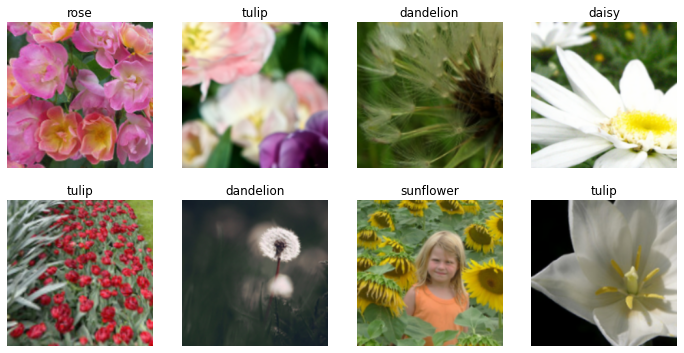

In [44]:
#Train Dataloader
dls.train.show_batch(max_n=8, nrows=2)

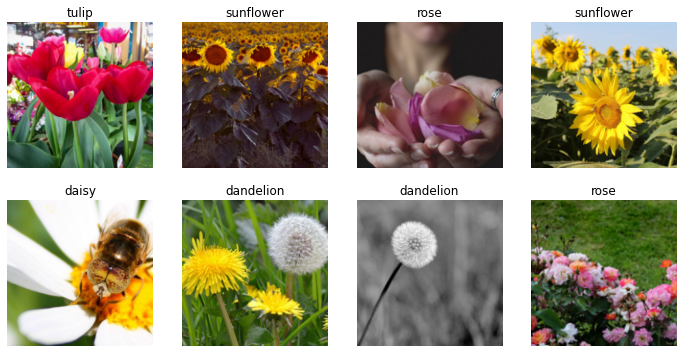

In [45]:
#Valid DataLoader
dls.valid.show_batch(max_n=8, nrows=2)

In [46]:
#The labels in the DataSet
dls.vocab

(#5) ['daisy','dandelion','rose','sunflower','tulip']

Model Tuning

In [55]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [56]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.074982,0.335577,0.116898,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.478604,0.277700,0.085648,00:31
1,0.329329,0.214497,0.062500,00:31
2,0.219595,0.181667,0.053241,00:31


Identify items model had trouble with

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

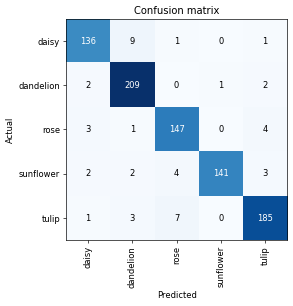

In [58]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

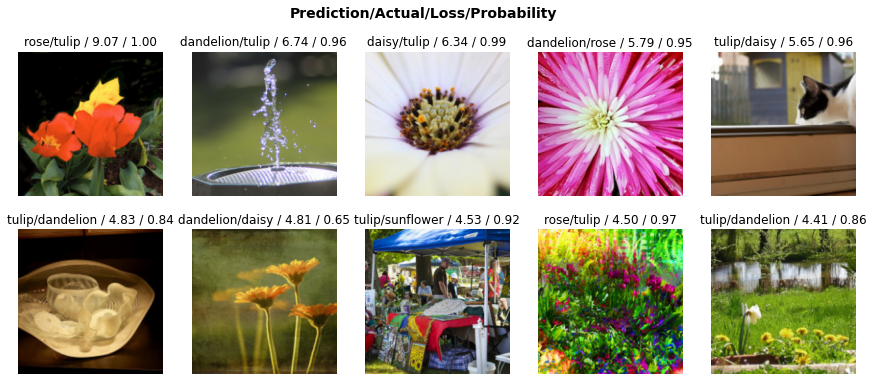

In [59]:
#sometimes, our Dataset can have mislabelling as seen below. 
#Running a FastAI model and plotting losses, can swiftly tell us what mistakes there could be, in the dataset
interp.plot_top_losses(10, nrows=2)

In [60]:
del learn , interp
gc.collect()

24391